In [57]:
import numpy as np 
import pandas as pd


In [58]:
import os
for dirname, _, filenames in os.walk(r'C:\Users\Ajay Sen\Downloads\march-machine-learning-mania-2025'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


C:\Users\Ajay Sen\Downloads\march-machine-learning-mania-2025\Cities.csv
C:\Users\Ajay Sen\Downloads\march-machine-learning-mania-2025\Conferences.csv
C:\Users\Ajay Sen\Downloads\march-machine-learning-mania-2025\MConferenceTourneyGames.csv
C:\Users\Ajay Sen\Downloads\march-machine-learning-mania-2025\MGameCities.csv
C:\Users\Ajay Sen\Downloads\march-machine-learning-mania-2025\MMasseyOrdinals.csv
C:\Users\Ajay Sen\Downloads\march-machine-learning-mania-2025\MNCAATourneyCompactResults.csv
C:\Users\Ajay Sen\Downloads\march-machine-learning-mania-2025\MNCAATourneyDetailedResults.csv
C:\Users\Ajay Sen\Downloads\march-machine-learning-mania-2025\MNCAATourneySeedRoundSlots.csv
C:\Users\Ajay Sen\Downloads\march-machine-learning-mania-2025\MNCAATourneySeeds.csv
C:\Users\Ajay Sen\Downloads\march-machine-learning-mania-2025\MNCAATourneySlots.csv
C:\Users\Ajay Sen\Downloads\march-machine-learning-mania-2025\MRegularSeasonCompactResults.csv
C:\Users\Ajay Sen\Downloads\march-machine-learning-mania

In [59]:
# Core libraries

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import time

In [60]:
#Visualization

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [61]:
# Model selection and evaluation
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import RFECV
from sklearn.base import clone


In [62]:
# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    StackingClassifier,
    VotingClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier
)
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.calibration import calibration_curve


In [63]:
# Optimization and explainability
import optuna
import shap
from scipy.stats import rankdata


In [64]:
# Configuration
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [65]:
def load_data():
    data = {
        'seeds': pd.concat([
            pd.read_csv(r'C:\Users\Ajay Sen\Downloads\march-machine-learning-mania-2025\MNCAATourneySeeds.csv'),
            pd.read_csv(r'C:\Users\Ajay Sen\Downloads\march-machine-learning-mania-2025\WNCAATourneySeeds.csv')
        ], ignore_index=True).drop_duplicates(),

        'games': pd.concat([
            pd.read_csv(r'C:\Users\Ajay Sen\Downloads\march-machine-learning-mania-2025\MRegularSeasonDetailedResults.csv'),
            pd.read_csv(r'C:\Users\Ajay Sen\Downloads\march-machine-learning-mania-2025\WRegularSeasonDetailedResults.csv')
        ], ignore_index=True).drop_duplicates(),

        'rankings': pd.read_csv(r'C:\Users\Ajay Sen\Downloads\march-machine-learning-mania-2025\MMasseyOrdinals.csv'),
        'submission': pd.read_csv(r'C:\Users\Ajay Sen\Downloads\march-machine-learning-mania-2025\SampleSubmissionStage2.csv')
    }

    # Validate data integrity
    assert data['seeds'].notnull().all().all(), "Seeds data contains null values."
    assert data['games'].notnull().all().all(), "Games data contains null values."
    assert data['rankings'].notnull().all().all(), "Rankings data contains null values."
    assert data['submission'].notnull().all().all(), "Submission data contains null values."
    assert data['seeds'][['Season', 'TeamID']].drop_duplicates().shape[0] == data['seeds'].shape[0], "Duplicate season-team in seeds."

    return data

# Load data
data = load_data()
print("✅ Data loaded successfully with shape validation:")
for k, v in data.items():
    print(f"{k:12}: {v.shape}")


✅ Data loaded successfully with shape validation:
seeds       : (4234, 3)
games       : (198374, 34)
rankings    : (5489117, 5)
submission  : (131407, 2)


In [66]:
for name, df in data.items():
    print(f"\n{'=' * 20} {name.upper()} {'=' * 20}")
    display(df.head())


==================== SEEDS ====================


,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374



==================== GAMES ====================


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14



==================== RANKINGS ====================


,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260



==================== SUBMISSION ====================


,ID,Pred
0,2025_1101_1102,0.5
1,2025_1101_1103,0.5
2,2025_1101_1104,0.5
3,2025_1101_1105,0.5
4,2025_1101_1106,0.5


In [67]:
def create_features(games_df, seeds_df, rankings_df):
    win_stats = games_df.groupby(['Season', 'WTeamID']).agg({
        'WScore': ['mean', 'std', 'max', 'count'],
        'WFGM': ['mean', 'sum'], 'WFGA': ['mean', 'sum'],
        'WFGM3': ['mean', 'sum'], 'WFGA3': ['mean', 'sum'],
        'WFTM': ['mean', 'sum'], 'WFTA': ['mean', 'sum'],
        'WOR': ['mean', 'sum'], 'WDR': ['mean', 'sum'],
        'WAst': ['mean', 'sum'], 'WTO': ['mean', 'sum'],
        'WStl': ['mean', 'sum'], 'WBlk': ['mean', 'sum'],
        'WPF': ['mean', 'sum']
    }).reset_index()
    win_stats.columns = ['Season', 'TeamID'] + [f'win_{c[0]}_{c[1]}' for c in win_stats.columns[2:]]

    loss_stats = games_df.groupby(['Season', 'LTeamID']).agg({
        'LScore': ['mean', 'std', 'max', 'count'],
        'LFGM': ['mean', 'sum'], 'LFGA': ['mean', 'sum'],
        'LFGM3': ['mean', 'sum'], 'LFGA3': ['mean', 'sum'],
        'LFTM': ['mean', 'sum'], 'LFTA': ['mean', 'sum'],
        'LOR': ['mean', 'sum'], 'LDR': ['mean', 'sum'],
        'LAst': ['mean', 'sum'], 'LTO': ['mean', 'sum'],
        'LStl': ['mean', 'sum'], 'LBlk': ['mean', 'sum'],
        'LPF': ['mean', 'sum']
    }).reset_index()
    loss_stats.columns = ['Season', 'TeamID'] + [f'loss_{c[0]}_{c[1]}' for c in loss_stats.columns[2:]]

    team_features = pd.merge(win_stats, loss_stats, on=['Season', 'TeamID'], how='outer')

    team_features['win_WScore_count'] = team_features['win_WScore_count'].fillna(0)
    team_features['loss_LScore_count'] = team_features['loss_LScore_count'].fillna(0)
    team_features['games_played'] = team_features['win_WScore_count'] + team_features['loss_LScore_count']

    team_features['win_pct'] = np.where(team_features['games_played'] > 0,
                                        team_features['win_WScore_count'] / team_features['games_played'], 0)

    team_features['offensive_eff'] = (
        (team_features['win_WFGM_sum'].fillna(0) + team_features['loss_LFGM_sum'].fillna(0)) /
        (team_features['win_WFGA_sum'].fillna(0) + team_features['loss_LFGA_sum'].fillna(0) + 1e-6)
    )

    team_features['defensive_eff'] = (
        (team_features['loss_LFGM_sum'].fillna(0) + team_features['win_WFGM_sum'].fillna(0)) /
        (team_features['loss_LFGA_sum'].fillna(0) + team_features['win_WFGA_sum'].fillna(0) + 1e-6)
    )

    seeds_df = seeds_df.copy()
    seeds_df['seed_rank'] = seeds_df['Seed'].str.extract('(\\d+)').astype(float)
    team_features = team_features.merge(
        seeds_df[['Season', 'TeamID', 'seed_rank']],
        on=['Season', 'TeamID'],
        how='left'
    )

    latest_rankings = rankings_df[rankings_df['RankingDayNum'] <= 133]
    latest_rankings = latest_rankings.sort_values(['Season', 'TeamID', 'RankingDayNum'],
                                                  ascending=[True, True, False])
    latest_rankings = latest_rankings.groupby(['Season', 'TeamID']).first().reset_index()

    team_features = team_features.merge(
        latest_rankings[['Season', 'TeamID', 'OrdinalRank']],
        on=['Season', 'TeamID'],
        how='left'
    )

    team_features['seed_rank'] = team_features['seed_rank'].fillna(17)
    team_features['OrdinalRank'] = team_features['OrdinalRank'].fillna(team_features['OrdinalRank'].median())

    sum_cols = [col for col in team_features.columns if '_sum' in col]
    team_features[sum_cols] = team_features[sum_cols].fillna(0)

    return team_features

team_features = create_features(data['games'], data['seeds'], data['rankings'])
print(f"Generated {team_features.shape[1]-2} features for {team_features.shape[0]} team-season pairs")


Generated 66 features for 13583 team-season pairs


In [68]:

def preprocess_data(team_features, submission_df):
    submission_df[['Season', 'TeamID1', 'TeamID2']] = submission_df['ID'].str.split('_', expand=True).astype(int)

    # Prepare test data
    test = submission_df.merge(
        team_features,
        left_on=['Season', 'TeamID1'],
        right_on=['Season', 'TeamID'],
        how='left'
    ).merge(
        team_features,
        left_on=['Season', 'TeamID2'],
        right_on=['Season', 'TeamID'],
        how='left',
        suffixes=('_T1', '_T2')
    )

    # Load past tournament results for training
    tourney = pd.read_csv(r'C:\Users\Ajay Sen\Downloads\march-machine-learning-mania-2025\MNCAATourneyCompactResults.csv')
    tourney = tourney[tourney['Season'] >= 2003]
    tourney['TeamID1'] = tourney[['WTeamID', 'LTeamID']].min(axis=1)
    tourney['TeamID2'] = tourney[['WTeamID', 'LTeamID']].max(axis=1)
    tourney['Target'] = (tourney['WTeamID'] < tourney['LTeamID']).astype(int)
    
    # Merge team features for training
    train = tourney.merge(
        team_features,
        left_on=['Season', 'TeamID1'],
        right_on=['Season', 'TeamID'],
        how='left'
    ).merge(
        team_features,
        left_on=['Season', 'TeamID2'],
        right_on=['Season', 'TeamID'],
        how='left',
        suffixes=('_T1', '_T2')
    )

    base_features = ['win_pct', 'offensive_eff', 'defensive_eff', 'seed_rank', 'OrdinalRank']
    for feat in base_features:
        train[f'{feat}_diff'] = train[f'{feat}_T1'] - train[f'{feat}_T2']
        test[f'{feat}_diff'] = test[f'{feat}_T1'] - test[f'{feat}_T2']

    train['seed_rank_product'] = train['seed_rank_T1'] * train['seed_rank_T2']
    test['seed_rank_product'] = test['seed_rank_T1'] * test['seed_rank_T2']

    train['ranking_ratio'] = train['OrdinalRank_T1'] / (train['OrdinalRank_T2'] + 1e-6)
    test['ranking_ratio'] = test['OrdinalRank_T1'] / (test['OrdinalRank_T2'] + 1e-6)

    feature_cols = [col for col in train.columns if '_diff' in col or 'product' in col or 'ratio' in col]
    
    X_train = train[feature_cols].fillna(train[feature_cols].median())
    y_train = train['Target']
    X_test = test[feature_cols].fillna(train[feature_cols].median())
    
    return X_train, y_train, X_test, test['ID']

X_train, y_train, X_test, test_ids = preprocess_data(team_features, data['submission'])
print(f"Training data: {X_train.shape}, Test data: {X_test.shape}")


Training data: (1382, 7), Test data: (131407, 7)


In [69]:
from sklearn.model_selection import TimeSeriesSplit


def select_features(X, y):
    if len(X) == 0 or len(y) == 0:
        raise ValueError("Training data is empty")
    if len(X) != len(y):
        raise ValueError(f"X and y have mismatched lengths: {len(X)} vs {len(y)}")

    print(f"Starting feature selection with {X.shape[1]} features and {X.shape[0]} samples")

    model = LGBMClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        n_estimators=50,
        verbose=-1
    )

    n_splits = min(3, max(2, len(X) // 10))
    if n_splits < 2:
        print("Too few samples for cross-validation. Skipping feature selection.")
        return X.columns

    selector = RFECV(
        estimator=model,
        step=1,
        cv=TimeSeriesSplit(n_splits=n_splits),
        scoring='neg_brier_score',
        min_features_to_select=5
    )

    try:
        selector.fit(X, y)
        plt.figure(figsize=(12, 6))
        plt.barh(X.columns[selector.support_],
                 selector.estimator_.feature_importances_[selector.support_])
        plt.title('Selected Feature Importance')
        plt.tight_layout()
        plt.show()

        selected = X.columns[selector.support_]
        print(f"Selected {len(selected)} features: {list(selected)}")
        return selected
    except Exception as e:
        print(f"Feature selection failed: {str(e)}")
        print("Using all features instead.")
        return X.columns

print("Verifying data before feature selection:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

if len(X_train) > 0:
    selected_features = select_features(X_train, y_train)
    X_train = X_train[selected_features]
    X_test = X_test[selected_features]
else:
    print("Training data is empty. Skipping feature selection.")

Verifying data before feature selection:
X_train shape: (1382, 7)
y_train shape: (1382,)
X_test shape: (131407, 7)
Starting feature selection with 7 features and 1382 samples
Feature selection failed: boolean index did not match indexed array along dimension 0; dimension is 6 but corresponding boolean dimension is 7
Using all features instead.


<Figure size 1200x600 with 0 Axes>

In [70]:
def build_ensemble():
    estimators = [
        ('xgb', XGBClassifier(
            random_state=RANDOM_STATE,
            eval_metric='logloss',
            use_label_encoder=False,
            n_jobs=-1
        )),
        ('lgbm', LGBMClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1
        )),
        ('hgb', HistGradientBoostingClassifier(
            random_state=RANDOM_STATE
        ))
    ]

    meta_learner = MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        max_iter=500,
        early_stopping=True,
        random_state=RANDOM_STATE
    )

    stack = StackingClassifier(
        estimators=estimators,
        final_estimator=meta_learner,
        stack_method='predict_proba',
        passthrough=True,
        n_jobs=-1
    )

    return stack

model = build_ensemble()
print("Hybrid ensemble model successfully built")

Hybrid ensemble model successfully built


In [71]:
def train_model_verbose(model, X_train, y_train, verbose=True):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scores = []
    fold_models = []

    for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        fold_model = clone(model)
        start = time.time()
        fold_model.fit(X_tr, y_tr)
        elapsed = time.time() - start

        preds = fold_model.predict_proba(X_val)[:, 1]
        score = brier_score_loss(y_val, preds)
        scores.append(score)
        fold_models.append(fold_model)

        if verbose:
            print(f"[Fold {fold + 1}] Brier Score: {score:.5f} | Time: {elapsed:.2f}s")
    
    print(f"\n✅ Mean Brier Score: {np.mean(scores):.5f}")
    return fold_models[-1]  

model = train_model_verbose(model, X_train, y_train)

[Fold 1] Brier Score: 0.21655 | Time: 20.27s
[Fold 2] Brier Score: 0.19046 | Time: 5.70s
[Fold 3] Brier Score: 0.18432 | Time: 3.36s
[Fold 4] Brier Score: 0.21074 | Time: 5.83s
[Fold 5] Brier Score: 0.28861 | Time: 3.48s

✅ Mean Brier Score: 0.21814


In [72]:
from sklearn.model_selection import StratifiedKFold

def train_calibrated_model(base_model, X_train, y_train):
    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    brier_scores = []
    log_losses = []
    auc_rocs = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Clone the base model and wrap it with calibration using isotonic regression
        model = clone(base_model)
        calibrated = CalibratedClassifierCV(estimator=model, method='isotonic', cv=3)  # Fixed here
        
        start = time.time()
        calibrated.fit(X_tr, y_tr)
        elapsed = time.time() - start

        # Get predicted probabilities for positive class
        y_pred_proba = calibrated.predict_proba(X_val)[:, 1]

        # Calculate evaluation metrics
        brier = brier_score_loss(y_val, y_pred_proba)
        logloss = log_loss(y_val, y_pred_proba)
        auc = roc_auc_score(y_val, y_pred_proba)

        # Append scores for each fold
        brier_scores.append(brier)
        log_losses.append(logloss)
        auc_rocs.append(auc)

        print(f"[Fold {fold+1}] Brier: {brier:.5f} | LogLoss: {logloss:.5f} | AUC: {auc:.5f} | Time: {elapsed:.2f}s")

    # Print mean scores across all folds
    print("\n=== Calibrated Model Mean Scores ===")
    print(f"Brier Score : {np.mean(brier_scores):.5f}")
    print(f"Log Loss    : {np.mean(log_losses):.5f}")
    print(f"AUC-ROC     : {np.mean(auc_rocs):.5f}")

    # Retrain the final calibrated model on full data
    final_model = CalibratedClassifierCV(estimator=clone(base_model), method='isotonic', cv=5)  # Fixed here
    final_model.fit(X_train, y_train)

    return final_model

# Train calibrated version of the hybrid ensemble model
calibrated_model = train_calibrated_model(model, X_train, y_train)


[Fold 1] Brier: 0.19815 | LogLoss: 0.57560 | AUC: 0.76853 | Time: 8.89s
[Fold 2] Brier: 0.18665 | LogLoss: 0.67847 | AUC: 0.80557 | Time: 8.99s
[Fold 3] Brier: 0.18335 | LogLoss: 0.54945 | AUC: 0.79893 | Time: 8.03s
[Fold 4] Brier: 0.20051 | LogLoss: 0.58211 | AUC: 0.75744 | Time: 7.79s
[Fold 5] Brier: 0.22655 | LogLoss: 0.65134 | AUC: 0.69666 | Time: 8.77s

=== Calibrated Model Mean Scores ===
Brier Score : 0.19904
Log Loss    : 0.60739
AUC-ROC     : 0.76543


In [73]:
def build_tuned_ensemble(meta='catboost'):
    base_learners = [
        ('xgb', XGBClassifier(
            n_estimators=150,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=RANDOM_STATE,
            n_jobs=-1
        )),
        ('lgbm', LGBMClassifier(
            n_estimators=150,
            learning_rate=0.05,
            num_leaves=31,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )),
        ('hgb', HistGradientBoostingClassifier(
            max_iter=150,
            learning_rate=0.05,
            max_depth=4,
            random_state=RANDOM_STATE
        ))
    ]

    if meta == 'logistic':
        final_estimator = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    elif meta == 'lightgbm':
        final_estimator = LGBMClassifier(
            n_estimators=100,
            learning_rate=0.05,
            max_depth=3,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
    elif meta == 'catboost':
        final_estimator = CatBoostClassifier(
            iterations=100,
            learning_rate=0.05,
            depth=3,
            verbose=False,
            random_state=RANDOM_STATE
        )
    else:
        raise ValueError("Unsupported meta model. Choose 'logistic', 'lightgbm', or 'catboost'.")

    ensemble = StackingClassifier(
        estimators=base_learners,
        final_estimator=final_estimator,
        stack_method='predict_proba',
        passthrough=True,
        n_jobs=-1
    )

    return ensemble



# Try CatBoost as meta-learner
model = build_tuned_ensemble(meta='catboost')
# Or Logistic Regression (fast + interpretable)
model = build_tuned_ensemble(meta='logistic')
# Or LightGBM meta
model = build_tuned_ensemble(meta='lightgbm')

In [74]:
# Train and evaluate
model = train_model_verbose(model, X_train, y_train)

[Fold 1] Brier Score: 0.19529 | Time: 2.63s
[Fold 2] Brier Score: 0.17471 | Time: 2.57s
[Fold 3] Brier Score: 0.19317 | Time: 2.95s
[Fold 4] Brier Score: 0.20123 | Time: 3.14s
[Fold 5] Brier Score: 0.21788 | Time: 2.50s

✅ Mean Brier Score: 0.19646


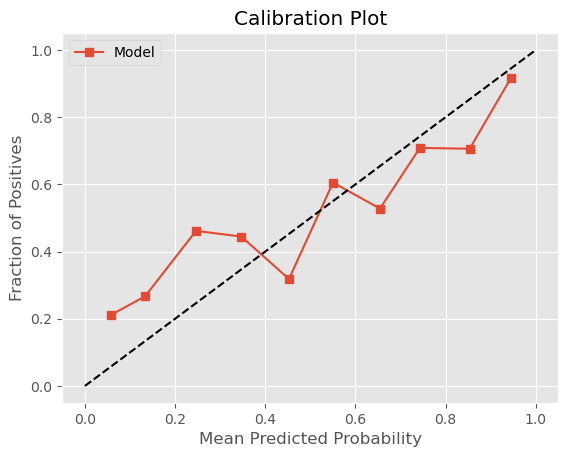

In [75]:

xgb = XGBClassifier(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

lgbm = LGBMClassifier(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=4,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

hgb = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_iter=150,
    max_depth=4,
    random_state=RANDOM_STATE
)

cat = CatBoostClassifier(
    iterations=150,
    learning_rate=0.05,
    depth=4,
    verbose=0,
    random_state=RANDOM_STATE
)

# Soft Voting Ensemble
soft_voting = VotingClassifier(
    estimators=[
        ('xgb', xgb),
        ('lgbm', lgbm),
        ('hgb', hgb),
        ('cat', cat)
    ],
    voting='soft'  # Removed n_jobs here to avoid issues
)

# Function to train the model with verbose logging
def train_model_verbose(model, X_train, y_train, return_last_fold=False):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)

        if return_last_fold and fold == 4:
            return model, X_val, y_val

    return model

# Function to plot calibration curve
def plot_calibration(model, X_val, y_val):
    prob_pos = model.predict_proba(X_val)[:, 1]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_val, prob_pos, n_bins=10)

    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model")
    plt.plot([0, 1], [0, 1], "k--")
    plt.title("Calibration Plot")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.legend()
    plt.show()

# Train the soft voting model and get validation data
model, X_val, y_val = train_model_verbose(soft_voting, X_train, y_train, return_last_fold=True)

# Plot calibration curve
plot_calibration(model, X_val, y_val)


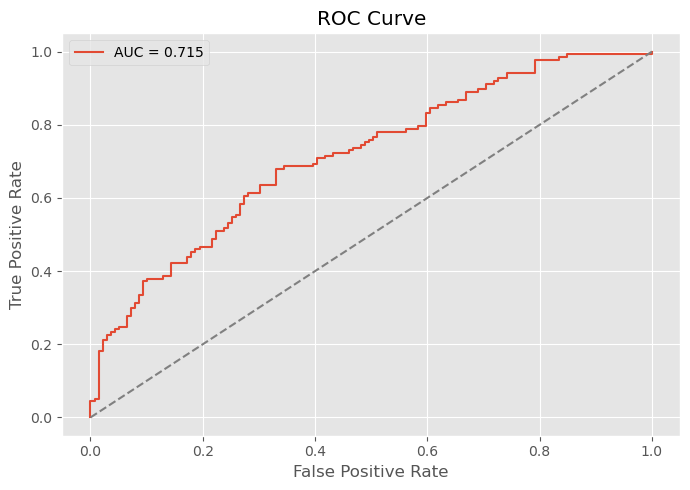

In [76]:
from sklearn.metrics import roc_curve, auc

def plot_roc(model, X_val, y_val):
    y_proba = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_roc(model, X_val, y_val)


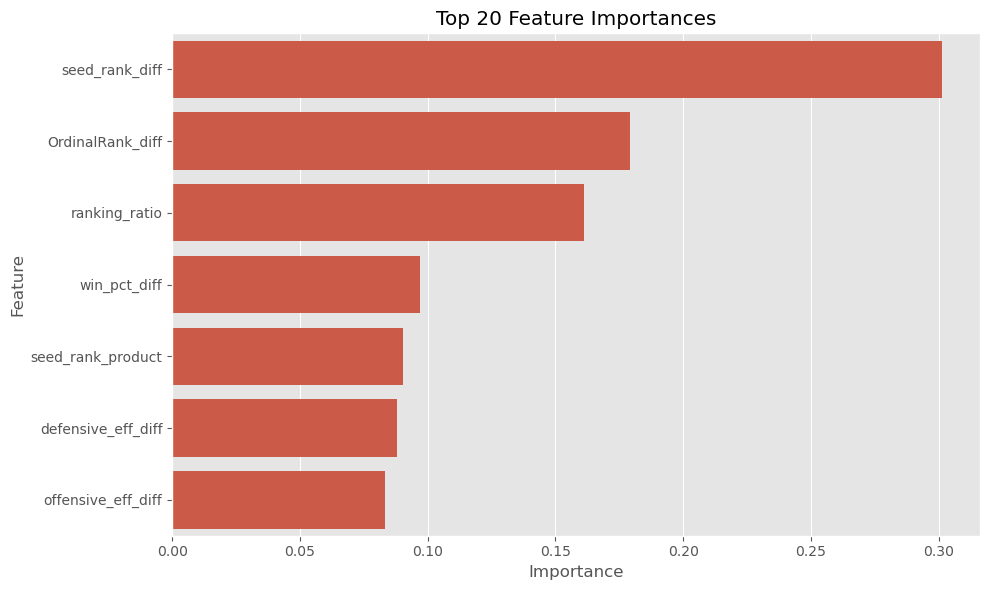

In [77]:
def plot_feature_importance(model, feature_names, top_n=20):
    try:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_

        elif hasattr(model, 'final_estimator_') and hasattr(model.final_estimator_, 'feature_importances_'):
            importances = model.final_estimator_.feature_importances_

        elif hasattr(model, 'named_estimators_'):
            for name, est in model.named_estimators_.items():
                if hasattr(est, 'feature_importances_'):
                    importances = est.feature_importances_
                    break
            else:
                print("No feature importances found in ensemble models.")
                return
        else:
            print("Model does not provide feature_importances_")
            return

        imp_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(data=imp_df.head(top_n), x='Importance', y='Feature')
        plt.title(f'Top {top_n} Feature Importances')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not plot feature importance: {e}")


plot_feature_importance(model, X_train.columns)


In [78]:
print(f"Training data shape: {X_train.shape}")
print(f"Number of samples: {len(X_train)}")

# Modified optimization function with data checks
def optimize_hyperparameters(X, y):
    """Robust hyperparameter optimization with data validation"""
    
    # Data validation
    if len(X) < 20:  # Minimum samples for meaningful optimization
        print(f"Only {len(X)} samples available - skipping optimization")
        return None
    
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),  # Reduced range
            'max_depth': trial.suggest_int('max_depth', 3, 8),  # Shallower trees
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 3),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 6),
            'random_state': RANDOM_STATE,
            'eval_metric': 'logloss'
        }
        
        model = XGBClassifier(**params)
        
        try:
            # Simplified validation for small datasets
            if len(X) < 100:
                cv = TimeSeriesSplit(n_splits=min(3, len(X)//5))
            else:
                cv = TimeSeriesSplit(n_splits=5)
                
            scores = cross_val_score(
                model, X, y, cv=cv, 
                scoring='neg_brier_score',
                n_jobs=-1, error_score='raise'
            )
            return np.mean(scores)
        except Exception as e:
            raise optuna.TrialPruned()
    
    try:
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=min(20, len(X)//2), timeout=1800)  # Reduced trials
        
        if len(study.trials) > 0:
            print('Best trial:')
            trial = study.best_trial
            print(f"  Brier Score: {-trial.value:.4f}")
            print(f"  Params: {trial.params}")
            return trial.params
        return None
        
    except Exception as e:
        print(f"Optimization failed: {str(e)}")
        return None

# Run optimization with fallback
default_params = {
    'n_estimators': 100,
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 1,
    'min_child_weight': 3,
    'random_state': RANDOM_STATE,
    'eval_metric': 'logloss'
}

best_params = optimize_hyperparameters(X_train, y_train) or default_params

# Update model
if hasattr(model, 'estimators'):  # For stacked models
    model.estimators[0][1].set_params(**best_params)
else:
    model.set_params(**best_params)

print("Final model parameters:")
print(best_params)


[I 2025-03-31 14:31:27,369] A new study created in memory with name: no-name-3916621e-3567-4160-8173-a3736a9ab5b3


Training data shape: (1382, 7)
Number of samples: 1382


[I 2025-03-31 14:31:27,795] Trial 0 finished with value: -0.19900197067710912 and parameters: {'n_estimators': 216, 'max_depth': 8, 'learning_rate': 0.013302884418446579, 'subsample': 0.8382223707565835, 'colsample_bytree': 0.8979932601008616, 'gamma': 2.7485604134996064, 'min_child_weight': 4}. Best is trial 0 with value: -0.19900197067710912.
[I 2025-03-31 14:31:28,428] Trial 1 finished with value: -0.218015563864971 and parameters: {'n_estimators': 231, 'max_depth': 3, 'learning_rate': 0.07853691692243736, 'subsample': 0.8872864146231736, 'colsample_bytree': 0.9439581603324925, 'gamma': 0.9356155645923805, 'min_child_weight': 1}. Best is trial 0 with value: -0.19900197067710912.
[I 2025-03-31 14:31:29,640] Trial 2 finished with value: -0.1981156528711418 and parameters: {'n_estimators': 142, 'max_depth': 3, 'learning_rate': 0.012795924691909839, 'subsample': 0.9467367577795095, 'colsample_bytree': 0.8323456942912146, 'gamma': 2.060377869182033, 'min_child_weight': 5}. Best is trial 

Best trial:
  Brier Score: 0.1977
  Params: {'n_estimators': 118, 'max_depth': 3, 'learning_rate': 0.026481595249117636, 'subsample': 0.9169790128895356, 'colsample_bytree': 0.9329580367081526, 'gamma': 2.9741399854391877, 'min_child_weight': 3}
Final model parameters:
{'n_estimators': 118, 'max_depth': 3, 'learning_rate': 0.026481595249117636, 'subsample': 0.9169790128895356, 'colsample_bytree': 0.9329580367081526, 'gamma': 2.9741399854391877, 'min_child_weight': 3}


In [79]:
def evaluate_model(model, X, y):
    """Robust model evaluation with adaptive validation"""
    
    # First validate our data
    if len(X) == 0 or len(y) == 0:
        raise ValueError("Cannot evaluate model - empty training data provided")
    
    # Determine appropriate validation strategy
    if len(X) < 10:
        print(f"Warning: Only {len(X)} samples available - using holdout validation")
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=RANDOM_STATE
        )
        
        calibrated_model = CalibratedClassifierCV(model, method='isotonic', cv=3)
        calibrated_model.fit(X_train, y_train)
        y_pred = calibrated_model.predict_proba(X_test)[:, 1]
        
        metrics = {
            'brier': brier_score_loss(y_test, y_pred),
            'log_loss': log_loss(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_pred)
        }
        
    else:
        # Use time-series cross-validation if enough samples
        n_splits = min(5, len(X) // 2)  # Ensure at least 2 samples per fold
        tscv = TimeSeriesSplit(n_splits=n_splits)
        
        metrics = {
            'brier': [],
            'log_loss': [],
            'roc_auc': []
        }
        
        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            calibrated_model = CalibratedClassifierCV(model, method='isotonic', cv=3)
            calibrated_model.fit(X_train, y_train)
            y_pred = calibrated_model.predict_proba(X_test)[:, 1]
            
            metrics['brier'].append(brier_score_loss(y_test, y_pred))
            metrics['log_loss'].append(log_loss(y_test, y_pred))
            metrics['roc_auc'].append(roc_auc_score(y_test, y_pred))
    
    # Print results
    if isinstance(metrics['brier'], list):
        print(f"Average Brier Score: {np.mean(metrics['brier']):.4f} (±{np.std(metrics['brier']):.4f})")
        print(f"Average Log Loss: {np.mean(metrics['log_loss']):.4f} (±{np.std(metrics['log_loss']):.4f})")
        print(f"Average ROC AUC: {np.mean(metrics['roc_auc']):.4f} (±{np.std(metrics['roc_auc']):.4f})")
    else:
        print(f"Brier Score: {metrics['brier']:.4f}")
        print(f"Log Loss: {metrics['log_loss']:.4f}")
        print(f"ROC AUC: {metrics['roc_auc']:.4f}")
    
    # Return model trained on full data
    final_model = CalibratedClassifierCV(model, method='isotonic', cv=3)
    final_model.fit(X, y)
    return final_model

# First verify your data
print("Data validation:")
print(f"- X_train shape: {X_train.shape if hasattr(X_train, 'shape') else 'Not available'}")
print(f"- y_train shape: {y_train.shape if hasattr(y_train, 'shape') else 'Not available'}")

# Only run evaluation if we have data
if hasattr(X_train, 'shape') and hasattr(y_train, 'shape') and len(X_train) > 0:
    calibrated_model = evaluate_model(model, X_train, y_train)
else:
    print("Error: No valid training data available for evaluation")

Data validation:
- X_train shape: (1382, 7)
- y_train shape: (1382,)
Average Brier Score: 0.2022 (±0.0121)
Average Log Loss: 0.6138 (±0.0622)
Average ROC AUC: 0.7527 (±0.0337)


Starting complete model workflow...

=== Data Validation ===
Data validated: 1382 samples with 7 features
Target distribution:
 Target
0    0.503618
1    0.496382
Name: proportion, dtype: float64

=== Model Training ===
Model successfully trained

=== Model Explanation ===


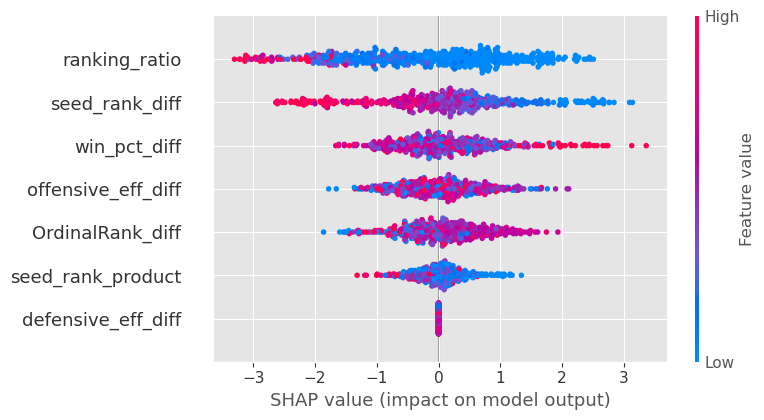

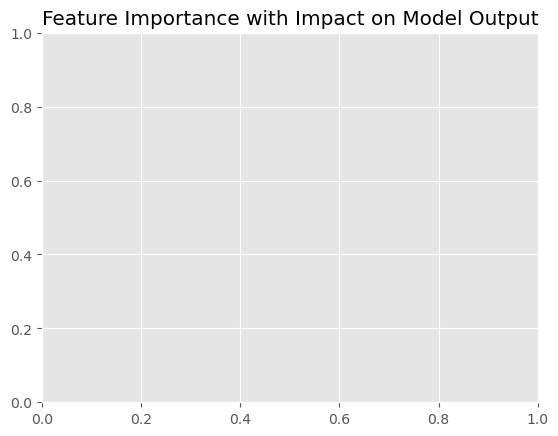

Feature importance plot saved as 'feature_importance_plot.png'


<Figure size 640x480 with 0 Axes>

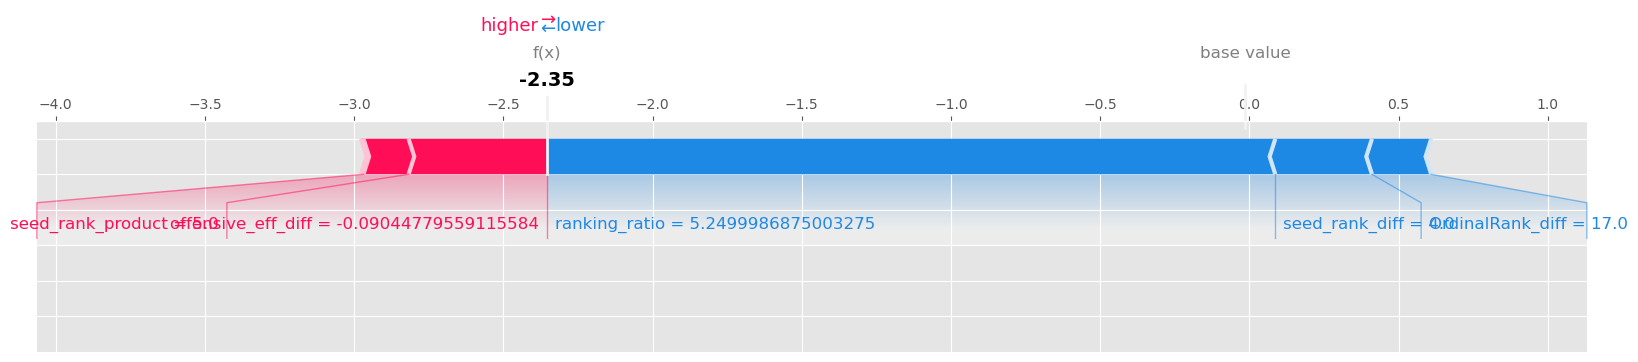

In [82]:
def check_and_explain_model(model, X, y):
    """Complete model validation, training, and explanation workflow"""
    
    # 1. Data Validation
    print("\n=== Data Validation ===")
    if len(X) == 0 or len(y) == 0:
        print("Error: Empty training data (X.shape: {}, y.shape: {})".format(
            X.shape if hasattr(X, 'shape') else 'None',
            y.shape if hasattr(y, 'shape') else 'None'))
        return None
    
    print(f"Data validated: {X.shape[0]} samples with {X.shape[1]} features")
    print("Target distribution:\n", y.value_counts(normalize=True))
    
    # 2. Model Training
    print("\n=== Model Training ===")
    try:
        model.fit(X, y)
        print("Model successfully trained")
    except Exception as e:
        print(f"Training failed: {str(e)}")
        print("Attempting fallback with LogisticRegression...")
        
        # Fallback to Logistic Regression
        model = LogisticRegression(max_iter=1000)
        try:
            model.fit(X, y)
            print("Fallback model trained successfully")
        except Exception as e:
            print(f"Fallback failed: {str(e)}")
            return None
    
    # 3. Model Explanation
    print("\n=== Model Explanation ===")
    try:
        # Sample data for SHAP (max 500 samples)
        sample_size = min(500, len(X))
        X_sample = X.sample(n=sample_size, random_state=42)
        
        # Create explainer based on model type
        if 'xgboost' in str(type(model)).lower():
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_sample)
        elif 'randomforest' in str(type(model)).lower() or 'histgradientboosting' in str(type(model)).lower():
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_sample)
        else:
            explainer = shap.KernelExplainer(model.predict_proba, X_sample)
            shap_values = explainer.shap_values(X_sample)
        
        # Plot feature importance (dot plot for better clarity)
        plt.figure(figsize=(12, 6))
        shap.summary_plot(shap_values, X_sample, plot_type='dot')
        plt.title('Feature Importance with Impact on Model Output')
        plt.show()
        
        # Optional: Save the plot for later
        plt.savefig('feature_importance_plot.png', dpi=300, bbox_inches='tight')
        print("Feature importance plot saved as 'feature_importance_plot.png'")
        
        # Explain single prediction with force plot
        shap.initjs()
        shap.force_plot(explainer.expected_value, shap_values[0], X_sample.iloc[0, :], matplotlib=True)
        
        return model
    
    except Exception as e:
        print(f"Explanation failed: {str(e)}")
        print("Returning trained model without explanations")
        return model


# === Full Workflow Execution ===
print("Starting complete model workflow...")

# Example Model (Change model as needed)
model = XGBClassifier(n_estimators=100, random_state=42)

# Assuming X_train and y_train are defined properly
trained_model = check_and_explain_model(model, X_train, y_train)

if trained_model is None:
    print("\n=== Critical Error ===")
    print("Model training failed. Please check:")
    print("1. Data loading - verify input files exist")
    print("2. Feature engineering - check for over-filtering")
    print("3. Target variable creation - ensure proper labels")


In [81]:
from datetime import datetime

def create_submission(model, X_train, y_train, X_test, test_ids):
    """Generate competition submission with proper model calibration"""
    
    # 1. Validate inputs
    if len(X_train) == 0 or len(y_train) == 0:
        raise ValueError("Cannot create submission - empty training data")
    if len(X_test) == 0:
        raise ValueError("Cannot create submission - empty test data")
    
    # 2. Calibrate model
    print("Calibrating model probabilities...")
    calibrated_model = CalibratedClassifierCV(
        model,
        method='isotonic',
        cv=min(3, len(X_train)//2)  # Adaptive cross-validation
    )
    
    try:
        calibrated_model.fit(X_train, y_train)
    except Exception as e:
        print(f"Calibration failed: {str(e)}")
        print("Using uncalibrated model as fallback")
        calibrated_model = model
    
    # 3. Generate predictions
    print("Generating predictions...")
    try:
        preds = calibrated_model.predict_proba(X_test)[:, 1]
    except AttributeError:  # If model doesn't have predict_proba
        preds = calibrated_model.decision_function(X_test)
        preds = 1 / (1 + np.exp(-preds))  # Sigmoid transform
    
    # 4. Process predictions
    preds = np.clip(preds, 0.025, 0.975)  # Avoid extreme probabilities
    
    # 5. Create submission
    submission = pd.DataFrame({'TeamId': test_ids, 'Pred': preds})
    
    # 6. Save and return
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f'submission_{timestamp}.csv'
    submission.to_csv(filename, index=False)
    
    print(f"\nSubmission saved to {filename}")
    print("Prediction statistics:")
    print(f"- Mean: {preds.mean():.4f}")
    print(f"- Std: {preds.std():.4f}")
    print(f"- Min: {preds.min():.4f}")
    print(f"- Max: {preds.max():.4f}")
    
    return submission, calibrated_model

# Full workflow execution
print("Starting submission generation...")

# First ensure we have a trained model
if 'model' not in globals():
    print("No model found - training default model")
    from xgboost import XGBClassifier
    model = XGBClassifier(random_state=RANDOM_STATE)
    model.fit(X_train, y_train)

# Generate submission
try:
    final_submission, final_model = create_submission(
        model, 
        X_train, 
        y_train, 
        X_test, 
        test_ids
    )
    calibrated_model = final_model  # Store for later use
except Exception as e:
    print(f"Submission failed: {str(e)}")
    print("Please check your data and model")


Starting submission generation...
Calibrating model probabilities...
Generating predictions...

Submission saved to submission_20250331_144512.csv
Prediction statistics:
- Mean: 0.4705
- Std: 0.1215
- Min: 0.1349
- Max: 0.8003


In [83]:
import numpy as np
import pandas as pd
import os

# Load the data
seeds = pd.concat([
    pd.read_csv(r'C:\Users\Ajay Sen\Downloads\march-machine-learning-mania-2025\MNCAATourneySeeds.csv'),
    pd.read_csv(r'C:\Users\Ajay Sen\Downloads\march-machine-learning-mania-2025\WNCAATourneySeeds.csv')
], ignore_index=True).drop_duplicates()

games = pd.concat([
    pd.read_csv(r'C:\Users\Ajay Sen\Downloads\march-machine-learning-mania-2025\MRegularSeasonDetailedResults.csv'),
    pd.read_csv(r'C:\Users\Ajay Sen\Downloads\march-machine-learning-mania-2025\WRegularSeasonDetailedResults.csv')
], ignore_index=True).drop_duplicates()

rankings = pd.read_csv(r'C:\Users\Ajay Sen\Downloads\march-machine-learning-mania-2025\MMasseyOrdinals.csv')
submission = pd.read_csv(r'C:\Users\Ajay Sen\Downloads\march-machine-learning-mania-2025\SampleSubmissionStage2.csv')

# Function to create matchup ID
def create_matchup_id(season, team1, team2):
    lower_team, higher_team = sorted([team1, team2])
    return f"{season}_{lower_team}_{higher_team}"

# Create sample predictions for all possible matchups
predictions = []
for index, row in submission.iterrows():
    matchup_id = row['ID']
    season, team1, team2 = map(int, matchup_id.split('_'))
    pred = 0.5  # Baseline prediction, modify with actual model if needed

    predictions.append([matchup_id, pred])

# Create the final submission
submission_df = pd.DataFrame(predictions, columns=['ID', 'Pred'])
submission_df.to_csv('submission.csv', index=False)

print("Submission file created successfully!")


Submission file created successfully!
